In [83]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

In [84]:
df1 = pd.read_csv('NBA Stats.csv')

In [85]:
del df1['Unnamed: 0']


In [86]:
#Need to Convert Date to Date/Time
#Parse the date and create seperate column for months
df1['Date']= pd.to_datetime(df1['Date'], format = '%m/%d/%Y', errors = 'coerce')
df1['Year']= df1['Date'].dt.year
df1['Month'] = df1['Date'].dt.month
df1['Day_num'] = df1['Date'].dt.day




In [87]:
del df1['Date']

In [88]:
df1.head()

,Team,Game,Home,Opponent,WINorLOSS,TeamPoints,OpponentPoints,FieldGoals,FieldGoalsAttempted,FieldGoals.,...,Opp.OffRebounds,Opp.TotalRebounds,Opp.Assists,Opp.Steals,Opp.Blocks,Opp.Turnovers,Opp.TotalFouls,Year,Month,Day_num
0,ATL,1,Away,TOR,L,102,109,40,80,0.500,...,16,48,26,13,9,9,22,2014,10,29
1,ATL,2,Home,IND,W,102,92,35,69,0.507,...,11,44,25,5,5,18,26,2014,11,1
2,ATL,3,Away,SAS,L,92,94,38,92,0.413,...,11,50,25,7,9,19,15,2014,11,5
3,ATL,4,Away,CHO,L,119,122,43,93,0.462,...,11,51,31,6,7,19,30,2014,11,7
4,ATL,5,Home,NYK,W,103,96,33,81,0.407,...,13,44,26,2,6,15,29,2014,11,8


In [89]:
#Convert Game, Home, Win/Loss,Year, Day_num to Category
df1['Game'] = pd.Categorical(df1.Game, ordered = True)
df1['Home'] = pd.Categorical(df1.Home)
df1['WINorLOSS'] = df1['WINorLOSS'].map({'W':1, 'L':0})
df1['Year']=pd.Categorical(df1.Year)
df1['Day_num']=pd.Categorical(df1.Day_num)
df1['Team']= pd.Categorical(df1.Team)
df1['Opponent'] = pd.Categorical(df1.Opponent)
#To Practice replacing values, change #'s in month to their corresponding Month abbreviation'
df1['Month'] = df1['Month'].map({10: 'Oct', 11: 'Nov', 12:'Dec', 1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr'})

In [90]:
df1['Month']= pd.Categorical(df1.Month)

In [91]:
#Make a for loop so all shooting percentage columns are sent from decimals to whole numbers
#Shooting percentage columnns are indicated by the period at the end of the column header
#First Need to Rename Columns
df1.rename(columns = {'Home':'Location','FieldGoals':'FG', 'FieldGoalsAttempted':'FGA','FieldGoals.':'FG%', 'X3PointShots':'3ptShots', 'X3PointShotsAttempted':'3ptShotsAtt',
                      'X3PointShots.': '3ptShot%', 'FreeThrows':'FT', 'FreeThrowsAttempted':'FTA', 'FreeThrows.':'FT%', 'Assists':'AST', 
                      'Steals':'STL','OffRebounds':'OREB', 'TotalRebounds':'REB', 'Blocks':'BLK', 'Turnovers':'TO'}, inplace = True)

In [92]:
#Convert shooting percentages to whole numbers
shot_perc = ['FG%', '3ptShot%', 'FT%']
for i in shot_perc:
    df1[i] = df1[i] *100

In [93]:
#Probably won't need the day number of the month. Let's get rid of this column
del df1['Day_num']
df1['Point_Dif'] = df1['TeamPoints'] - df1['OpponentPoints']

In [94]:
#rearrange a dataframe so into the order we want the columns
df1= df1[['Team', 'Game', 'Year', 'Month', 'Location', 'Opponent', 'WINorLOSS', 'TeamPoints', 'Point_Dif', 'FG', 'FGA', 'FG%', '3ptShots', '3ptShotsAtt', '3ptShot%', 'FT', 'FTA', 'FT%', 'OREB', 'REB', 'AST', 'STL', 'BLK', 'TO', 'TotalFouls']]

In [95]:
#Data Analysis/ Exploration
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9840 entries, 0 to 9839
Data columns (total 25 columns):
Team           9840 non-null category
Game           9840 non-null category
Year           9840 non-null category
Month          9840 non-null category
Location       9840 non-null category
Opponent       9840 non-null category
WINorLOSS      9840 non-null int64
TeamPoints     9840 non-null int64
Point_Dif      9840 non-null int64
FG             9840 non-null int64
FGA            9840 non-null int64
FG%            9840 non-null float64
3ptShots       9840 non-null int64
3ptShotsAtt    9840 non-null int64
3ptShot%       9840 non-null float64
FT             9840 non-null int64
FTA            9840 non-null int64
FT%            9840 non-null float64
OREB           9840 non-null int64
REB            9840 non-null int64
AST            9840 non-null int64
STL            9840 non-null int64
BLK            9840 non-null int64
TO             9840 non-null int64
TotalFouls     9840 non-null 

In [96]:
df1.head()

,Team,Game,Year,Month,Location,Opponent,WINorLOSS,TeamPoints,Point_Dif,FG,...,FT,FTA,FT%,OREB,REB,AST,STL,BLK,TO,TotalFouls
0,ATL,1,2014,Oct,Away,TOR,0,102,-7,40,...,9,17,52.9,10,42,26,6,8,17,24
1,ATL,2,2014,Nov,Home,IND,1,102,10,35,...,25,33,75.8,3,37,26,10,6,12,20
2,ATL,3,2014,Nov,Away,SAS,0,92,-2,38,...,8,11,72.7,10,37,26,14,5,13,25
3,ATL,4,2014,Nov,Away,CHO,0,119,-3,43,...,20,26,76.9,7,38,28,8,3,19,33
4,ATL,5,2014,Nov,Home,NYK,1,103,7,33,...,28,36,77.8,12,41,18,10,5,8,17


In [97]:
df1.describe(include = 'all')  

,Team,Game,Year,Month,Location,Opponent,WINorLOSS,TeamPoints,Point_Dif,FG,...,FT,FTA,FT%,OREB,REB,AST,STL,BLK,TO,TotalFouls
count,9840,9840.0,9840.0,9840,9840,9840,9840.000000,9840.000000,9840.000000,9840.000000,...,9840.00000,9840.000000,9840.000000,9840.000000,9840.000000,9840.000000,9840.000000,9840.000000,9840.000000,9840.000000
unique,30,82.0,5.0,7,2,30,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,WAS,82.0,2017.0,Mar,Home,WAS,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,328,120.0,2536.0,1872,4920,328,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,103.652337,0.000000,38.602439,...,17.32063,22.749390,76.239492,10.287602,43.520630,22.546545,7.750508,4.827642,13.638618,20.058537
std,NaN,NaN,NaN,NaN,NaN,NaN,0.500025,12.188043,13.783533,5.029992,...,6.00262,7.390451,10.429704,3.807120,6.410428,5.122989,2.958886,2.536845,3.869543,4.317611
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,64.000000,-61.000000,19.000000,...,1.00000,1.000000,14.300000,0.000000,20.000000,6.000000,0.000000,0.000000,2.000000,7.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,95.000000,-9.000000,35.000000,...,13.00000,18.000000,69.600000,8.000000,39.000000,19.000000,6.000000,3.000000,11.000000,17.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,103.000000,0.000000,38.000000,...,17.00000,22.000000,76.900000,10.000000,43.000000,22.000000,8.000000,5.000000,13.000000,20.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,112.000000,9.000000,42.000000,...,21.00000,27.000000,83.300000,13.000000,48.000000,26.000000,10.000000,6.000000,16.000000,23.000000


Text(0, 0.5, 'Shooting %')

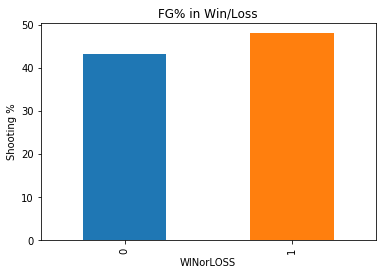

In [98]:
win_loss = df1[['WINorLOSS', 'FG%']].groupby('WINorLOSS')
fg = win_loss['FG%'].mean()
fg.plot(kind='bar')
plt.title('FG% in Win/Loss')
plt.ylabel('Shooting %')

In [99]:
#Need to create a graph/table showing the percentage of games won for home games and percentage of games won for away games
home_advantage = df1[['Location', 'WINorLOSS']].groupby('Location')
home_advantage.describe(include = 'all')

WINorLOSS                                             
             count      mean       std  min  25%  50%  75%  max
Location                                                       
Away        4920.0  0.418496  0.493363  0.0  0.0  0.0  1.0  1.0
Home        4920.0  0.581504  0.493363  0.0  0.0  1.0  1.0  1.0

C:\Users\donav\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


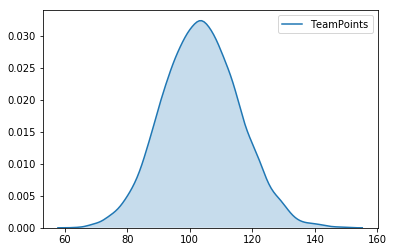

In [100]:
sns.kdeplot(df1['TeamPoints'], shade = True)
#Can see that it follow a normal distribution

In [101]:
month_pts = df1[['Month', 'TeamPoints']]
month_pts = month_pts.groupby('Month').mean()
month_pts = pd.DataFrame(month_pts)
month_pts = month_pts.reindex(['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr'])
month_pts

,TeamPoints
Month,
Oct,103.399061
Nov,102.352875
Dec,103.269022
Jan,103.768590
Feb,104.902588
Mar,104.128739
Apr,104.113300


([<matplotlib.axis.XTick at 0x1bb6d57d128>,
 <a list of 7 Text xticklabel objects>)

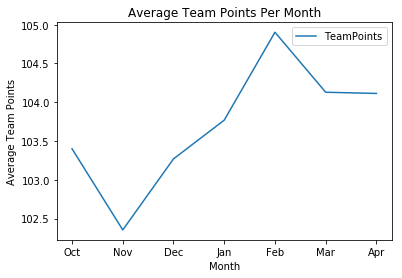

In [102]:
month_pts.plot()
plt.ylabel('Average Team Points')
plt.title('Average Team Points Per Month')
plt.xticks([0, 1,2,3,4,5,6], ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr'])

In [103]:
win_loss1 = df1[['WINorLOSS', 'FGA']]
win_loss1 = win_loss1.groupby('WINorLOSS').mean()
win_loss1 = pd.DataFrame(win_loss1)
win_loss1

,FGA
WINorLOSS,
0,85.199390
1,84.605488


In [104]:
#Easily see there's a large difference between 3ptshot% with wins and losses
three_ball = df1[['WINorLOSS', '3ptShots', '3ptShotsAtt', '3ptShot%']]
three_ball = three_ball.groupby('WINorLOSS').mean() 
three_ball

,3ptShots,3ptShotsAtt,3ptShot%
WINorLOSS,,,
0,8.261585,25.392276,32.328496
1,9.992073,25.855081,38.535752


In [105]:
ft = df1[['WINorLOSS', 'FT', 'FTA', 'FT%']]
ft = ft.groupby('WINorLOSS').mean() 
ft

,FT,FTA,FT%
WINorLOSS,,,
0,16.461789,21.912195,75.136382
1,18.179472,23.586585,77.342602


In [106]:
rebounds = df1[['WINorLOSS', 'OREB', 'REB']]
rebounds = rebounds.groupby('WINorLOSS').mean() 
rebounds

,OREB,REB
WINorLOSS,,
0,10.440854,41.854675
1,10.134350,45.186585


In [107]:
#can see there are more assists in teams that win vs teams that don't
rand = df1[['WINorLOSS', 'AST', 'STL', 'BLK', 'TO']]
rand = rand.groupby('WINorLOSS').mean() 
rand

,AST,STL,BLK,TO
WINorLOSS,,,,
0,20.949593,7.334756,4.401829,14.100813
1,24.143496,8.166260,5.253455,13.176423


In [108]:
fouls= df1[['WINorLOSS', 'TotalFouls']]
fouls = fouls.groupby('WINorLOSS').mean() 
fouls

,TotalFouls
WINorLOSS,
0,20.545528
1,19.571545


In [109]:
#Important to create this dataframe within machine learning data frame
steal_to = df1[['WINorLOSS', 'AST', 'TO']]
steal_to['AST_TO'] = df1['AST']/df1['TO']
steal_to1 = steal_to[['WINorLOSS', 'AST_TO']]
steal_to1 = steal_to1.groupby('WINorLOSS')
steal_to1.mean()

C:\Users\donav\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,AST_TO
WINorLOSS,
0,1.628425
1,2.003952


In [110]:
df1['AST_TO'] = df1['AST']/df1['TO']

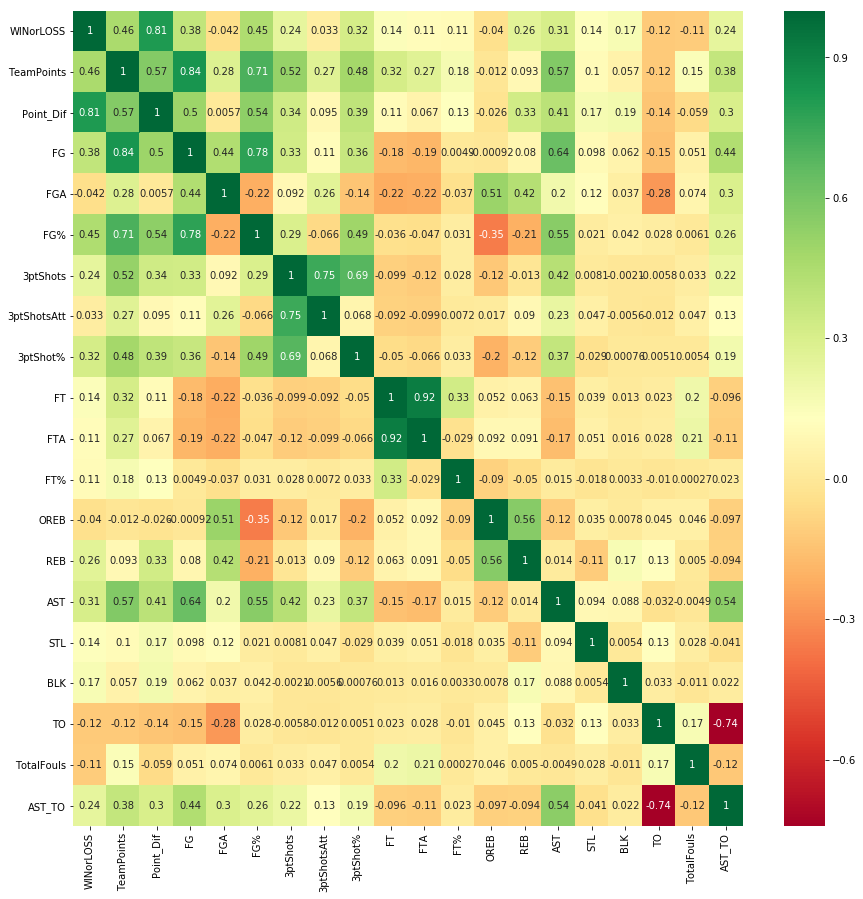

In [111]:
#Did not receive any good info using pairplots
corr= df1.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot = True, xticklabels = corr.columns, yticklabels = corr.columns, cmap="RdYlGn")
plt.show()
#Attributes shown with high correlations 
#WINorLOSS not associated with FGA, 3ptShotAtt, OREB, 
#Remove FG, OREB, Point_dif, FT

In [112]:
df1 = df1.drop(columns= ['FG', 'OREB', 'Point_Dif', 'FT', '3ptShots', '3ptShotsAtt', 'FGA','TO'])

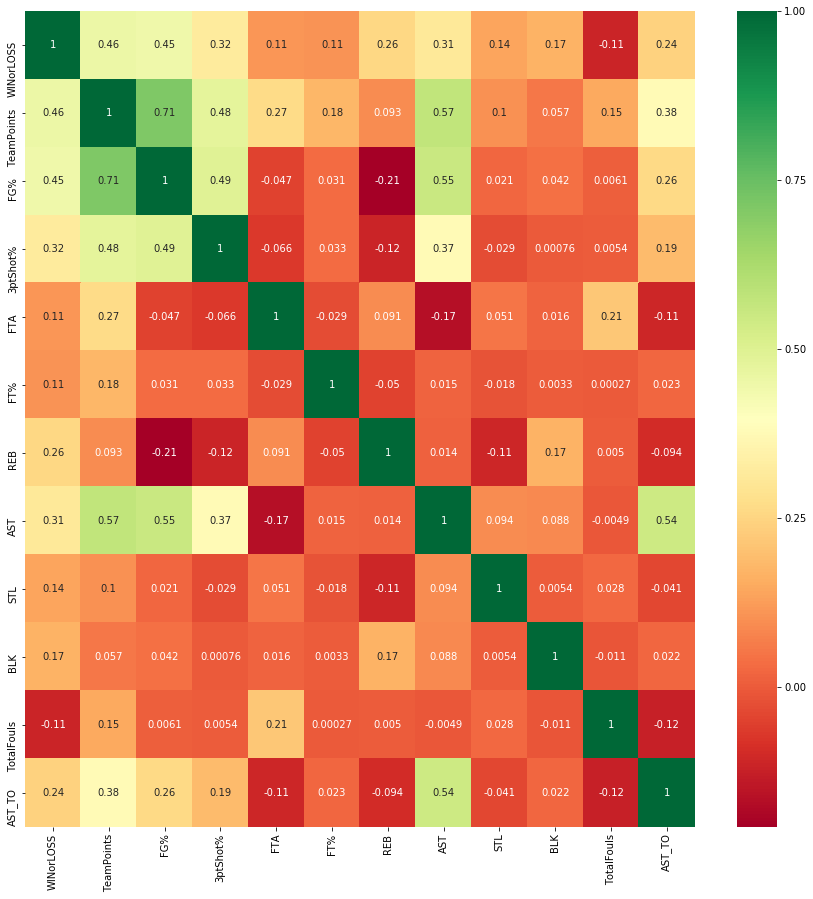

In [113]:
corr= df1.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot = True, xticklabels = corr.columns, yticklabels = corr.columns, cmap="RdYlGn")
plt.show()
#Look with TeamPoints removed

In [114]:
#Splitting the season into quarters
df1['Game'] = df1['Game'].astype(int)
df1.loc[df1['Game'] <= 20, 'Game'] = 0
df1.loc[(df1['Game'] > 20) & (df1['Game'] <= 41 ), 'Game'] = 1
df1.loc[(df1['Game'] > 41) & (df1['Game'] <= 61 ), 'Game'] = 2
df1.loc[(df1['Game'] > 61) & (df1['Game'] <= 82 ), 'Game'] = 3

In [115]:
df1 = pd.get_dummies(df1, columns = ['Team', 'Year', 'Opponent', 'Game', 'Location', 'Month'], drop_first = True)

In [116]:
df1.head()

,WINorLOSS,TeamPoints,FG%,3ptShot%,FTA,FT%,REB,AST,STL,BLK,...,Game_1,Game_2,Game_3,Location_Home,Month_Dec,Month_Feb,Month_Jan,Month_Mar,Month_Nov,Month_Oct
0,0,102,50.0,59.1,17,52.9,42,26,6,8,...,0,0,0,0,0,0,0,0,0,1
1,1,102,50.7,35.0,33,75.8,37,26,10,6,...,0,0,0,1,0,0,0,0,1,0
2,0,92,41.3,32.0,11,72.7,37,26,14,5,...,0,0,0,0,0,0,0,0,1,0
3,0,119,46.2,39.4,26,76.9,38,28,8,3,...,0,0,0,0,0,0,0,0,1,0
4,1,103,40.7,40.9,36,77.8,41,18,10,5,...,0,0,0,1,0,0,0,0,1,0


In [117]:
y = df1['WINorLOSS']
x = df1.drop('WINorLOSS', axis = 1)

In [118]:
#Create the test data frame
x_train1, x_test, y_train1, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [119]:
#Need to implement feature scaling
from sklearn.preprocessing import StandardScaler
columns = ['TeamPoints','FG%', '3ptShot%', 'FTA', 'FT%', 'REB', 'AST', 'STL', 'BLK', 'TotalFouls', 'AST_TO']

In [120]:
#FEature Scaling
scaler = StandardScaler()
x_train1[columns] = scaler.fit_transform(x_train1[columns])
x_test[columns] = scaler.transform(x_test[columns])

C:\Users\donav\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\donav\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\donav\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\donav\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [121]:
x_train1.head()

,TeamPoints,FG%,3ptShot%,FTA,FT%,REB,AST,STL,BLK,TotalFouls,...,Game_1,Game_2,Game_3,Location_Home,Month_Dec,Month_Feb,Month_Jan,Month_Mar,Month_Nov,Month_Oct
625,0.836331,0.493526,-0.350423,0.842124,-0.370348,-0.859293,-0.495281,-0.263360,-0.326056,1.146811,...,0,1,0,1,0,1,0,0,0,0
1922,-0.147458,0.017264,-0.769831,0.571041,0.145840,0.391917,-0.689922,-0.263360,0.464797,-0.941805,...,1,0,0,0,0,0,1,0,0,0
8448,0.672366,0.603432,-0.227669,-0.377750,-0.121813,-0.859293,0.867205,-0.263360,0.464797,0.914742,...,0,0,0,1,0,0,0,0,0,1
7276,-1.951071,-1.228345,-1.475665,-1.597623,-2.081415,0.391917,-0.884563,-0.601395,0.069370,0.682674,...,0,1,0,1,0,0,0,1,0,0
5229,-0.229440,0.127170,-0.227669,-0.242208,1.809112,-0.702892,-1.663126,-0.263360,1.255649,-0.709737,...,0,0,1,0,0,0,0,1,0,0


In [122]:
#Now we can start implementing machine learning models
#Linear Gradient Descent
sgd = SGDClassifier(max_iter = 500, tol = None)
sgd.fit(x_train1, y_train1)
sgd.score(x_train1, y_train1)
acc_sgd = round(sgd.score(x_train1, y_train1) * 100, 2)

C:\Users\donav\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


In [123]:
#Logistic Regression
logreg = LogisticRegression()
logreg.fit(x_train1, y_train1)
acc_logreg = round(logreg.score(x_train1, y_train1) * 100, 2)

C:\Users\donav\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [124]:
#Random Forest
random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(x_train1, y_train1)
acc_random_forest = round(random_forest.score(x_train1, y_train1) * 100, 2)

In [125]:
#K-Neighbors CLassifier
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train1, y_train1)
acc_knn = round(knn.score(x_train1, y_train1) * 100, 2)

In [126]:
#Guassian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(x_train1, y_train1)
acc_gaussian = round(gaussian.score(x_train1, y_train1)* 100, 2)

In [127]:
#Perceptron
perceptron = Perceptron(max_iter = 5)
perceptron.fit(x_train1, y_train1)
acc_perceptron = round(perceptron.score(x_train1, y_train1)*100, 2)

C:\Users\donav\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


In [128]:
#Linear Support Vector Machine
linear_svc = LinearSVC()
linear_svc.fit(x_train1, y_train1)
acc_linear_svc = round(linear_svc.score(x_train1, y_train1) *100, 2)

C:\Users\donav\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [129]:
#Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train1, y_train1)
acc_decision_tree = round(decision_tree.score(x_train1, y_train1)*100, 2)

In [130]:
#Which model had the greatest accuracy?
scores_df = pd.DataFrame({'Model': ['Linear Gradient Descent', 'Logistic Regresstion', 'Random Forest', 'KNN', 'Gaussian Naive Bayes', 'Perceptron', 'Linear Support Vector Machines', 'Decision Trees'], 'Score': [acc_sgd, acc_logreg, acc_random_forest, acc_knn, acc_gaussian, acc_perceptron, acc_linear_svc, acc_decision_tree]})
scores1_df = scores_df.sort_values(by = 'Score', ascending = False)
scores1_df = scores1_df.set_index('Score')
scores1_df

,Model
Score,
100.00,Random Forest
100.00,Decision Trees
86.70,KNN
85.49,Linear Support Vector Machines
85.43,Logistic Regresstion
85.32,Linear Gradient Descent
81.59,Perceptron
69.77,Gaussian Naive Bayes


In [131]:
#Because Random forests is a collection of decision trees we will use the Random Forest model as our classifier. 
#The model has an accuracy score of 100% which is very alarming. Lets run some cross validation to see if we can fix this.
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators = 100)
scores = cross_val_score(rf, x_train1, y_train1, cv=5, scoring = 'accuracy')
print(scores)
print(scores.mean())

[0.79568528 0.79796696 0.81130877 0.78907243 0.79860229]
0.7985271447829255


In [132]:
#Model's average accuracy is 80.11%
#Lets find the feature importance of the models
importances = pd.DataFrame({'feature': x_train1.columns, 'importance':np.round(random_forest.feature_importances_, 3)})
importances = importances.sort_values('importance', ascending = False)
importances

,feature,importance
1,FG%,0.133
0,TeamPoints,0.116
5,REB,0.093
2,3ptShot%,0.079
10,AST_TO,0.058
6,AST,0.050
4,FT%,0.043
9,TotalFouls,0.043
3,FTA,0.041
7,STL,0.041


In [133]:
#Forgot that the year was still in the model.
#In order ti predict results of a particular matchup the year in the model will not matter.
#ALso, the location of the game doesn't seem to matter as much either
#We'll drop both columns from our dataset
datasets = [x_train1, x_test]
for set in datasets:
    set.drop(['Year_2015', 'Year_2016', 'Year_2017', 'Year_2018', 'Location_Home', 'Game_1', 'Game_2', 'Game_3'], axis=1,  inplace = True)

C:\Users\donav\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [ ]:
#Our OOB score is slightly lower than the accuracy. We can possibly increase our accuracy with some hyperparameter tuning next.
#min_samples_split is the required amount of samples to be in each category in order to split the node
    #Example'2' would mean have 2 in short, tall and medium
#min_samples_leaf minimum number of samples to be at the leaf in order to categorize it as that type
#Finding the best parameters for the model
param_grid = { 'min_samples_split': [2, 5, 10, 25], 'min_samples_leaf': [ 1, 5, 10, 25, 50], 'n_estimators': [100, 300, 5000]}
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(n_estimators = 100, max_features = 'auto', oob_score=True, random_state=2, n_jobs = -1)

grid = GridSearchCV(estimator = rf, param_grid = param_grid, cv=3)

grid.fit(x_train1, y_train1)

In [ ]:
grid.best_params_

In [134]:
#Train the model with the dropped columns
rf = RandomForestClassifier(n_estimators=100, oob_score = True, random_state =1)
rf.fit(x_train1, y_train1)
rf_y_pred = rf.predict(x_test)
acc_rf = round(rf.score(x_train1, y_train1) * 100, 2)
acc_rf

100.0

In [135]:
#Now Lets use cross validation to see if our accuracy has truly grown
scores = cross_val_score(rf, x_train1, y_train1, cv = 5, scoring = 'accuracy')
print(scores)
print(scores.mean())

[0.79124365 0.80559085 0.8202033  0.79796696 0.79860229]
0.8027214120318114


In [136]:
#Our accuracy basically, stayed the same.. this reduction will help us better generalize our machine learning algorthim. 
#Thus, the reduction truly benefits us. 
#In a random forest classifier the Out of Bag samples (OOB) meausres the accuracy 
#of predictions with the decision trees within the forest that that certain observation was not used to build.
oob = round(rf.oob_score_, 4) * 100
oob

79.86999999999999

In [137]:
#Now fit the new model with the best parameters
rf = RandomForestClassifier(min_samples_leaf = 1, min_samples_split = 2, n_estimators = 500, oob_score = True, random_state=4)
rf.fit(x_train1, y_train1)
y_pred = rf.predict(x_test,)
print(round(rf.oob_score_, 4) *100)


80.41


In [138]:
#Further Evaluation
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

In [139]:
#Evaluate the confusion matrix
#It seems as if the model is making accurate predictions accross the board
pred = cross_val_predict(rf, x_train1, y_train1, cv=3)
print(confusion_matrix(y_train1, pred))
print('Precision: ', precision_score(y_train1, pred))
print('Recall: ', recall_score(y_train1, pred))
print('F1 Score: ', f1_score(y_train1, pred))

[[3139  772]
 [ 757 3204]]
Precision:  0.8058350100603622
Recall:  0.80888664478667
F1 Score:  0.8073579438074839


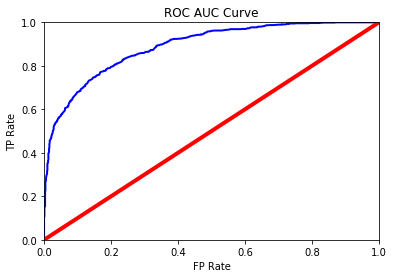

<Figure size 1008x504 with 0 Axes>

ROC-AUC Score:  0.8891581604971316


In [140]:
#ROC-AUC Score
y_scores = rf.predict_proba(x_test)
y_scores= y_scores[:,1]
fprate, tprate, thresh = roc_curve(y_test, y_scores)
plt.title('ROC AUC Curve')
plt.plot(fprate, tprate, 'b', linewidth=2)
plt.plot([0,1], [0,1], 'r', linewidth=4)
plt.axis([0,1,0,1])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.figure(figsize=(14,7))
plt.show()
print('ROC-AUC Score: ', roc_auc_score(y_test, y_scores))
#Represents the TP rate vs the FP rate. Our model seems to do a decent job. There is a major tradeoff as the more false positives the higher the true positive rate
#Think of this tradef
#ALso, our ROC-AUC score is very high at 89%. 